## Gone (randomly?) viral

### Final project in Modelling and Computational Engineering (MOD 510) Dec 2020

Lars B Lukerstuen (248800)

Joakim O Gjermundstad (251365)

# Exercise 4
In this notebook, we have implemented a custom random walk epidemic simulator. Our implementation features: 

A simulation space (grid) separated into 4 cities (quadrants) with varying population densities. The walkers cannot cross over the borders, but we have also implemented a city-travel function,where infected walkers have a certain probability to travel to another city, which is meant to emulate asymptomatic (or quarantine breakers) travelling between cities/countries, and potentially starting new outbreaks. We also implemented a social-distancing function where after the amount of infected reach a certain percentage of the population, movements will be reduced for a period which in turn would hopefully model the effects of social-distancing.   


### Limitations and areas of improvement 

Although we are happy with how the implementation turned out, we are not hesitant to admit that the model is not the greatest. For the first part, it is slow and running many simulations takes a lot of time even on a powerful computer. Also, some of the features could be improved. We would have preferred the social-distancing function to be individual to each of the cities, as in our implementation it is dependent on the total population. In addition, we are somewhat uncertain if this implementation models the effects of social-distancing accurately enough as we found it difficult to tune the parameters of the model to make the distinct plateaus in infection spread that enacting and then de-enacting such policies seem to create in real world data (double s-curves).   

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum
from scipy.optimize import curve_fit
from functools import reduce 
import pandas as pd

In [79]:
class DiseaseStatus(Enum):  
    SUSCEPTIBLE = 0
    INFECTIOUS = 1
    RECOVERED = 2
    DEAD = 3

class AgeStatus(Enum):
    YOUNG = 0
    OLD = 1  
    
class Citizenship(Enum):
    STAVANGER = 0
    OSLO = 1
    BERGEN = 2
    TRONDHEIM = 3

class StateSaver:
    def __init__(self):     
        self.infectious_cumulative =[]
        self.susceptible_cumulative =[]
        self.dead_cumulative = []
        self.dead_elderly = []
        self.recoveries_cumulative =[]
        self.recoveries_elderly = []
        self.dead_young =[]
        self.recoveries_young = []



class RandomWalkEpidemicSimulator:
    """
    Class used to model the spreading of a contagious disease in a
    population of individuals with a 2D random walk.

    Each walker has a disease status which is represented by an 
    integer Enum. Also, a set of integer (x, y)-coordinates are 
    stored for each walker. The possible coordinates are:

        {0, 1, ..., Lx-1} in the x-direction
        {0, 1, ..., Ly-1} in the y-direction

    It is only possible to move North, South, East, or West. If a 
    walker attempts to move outside of the physical domain, nothing 
    happens (i.e., a "bounce-back boundary condition" is enforced).
    """


    def __init__(self,population_size, no_init_infected,nx,ny, q,recovery_rate, death_rate_old,death_rate_young,travel_rate_asymptomatics,
    social_distancing_rate, social_distancing_duration, nth_elderly):
        """
        :param population_size: The total number of people (N).
        :param no_init_infected: The number of infected people at t=0.
        :param nx: The number of lattice nodes in the x-direction 
        :param ny: The number of lattice nodes in the y-direction.
        :param q: The probability of infection (0 <= q <= 1).
        """
        self.N_ = population_size
        self.I0_= no_init_infected
        self.nx_ = nx
        self.ny_ = ny 
        self.infection_probability_ = q
        self.nth_elderly = nth_elderly # every nth person is elderly
        self.recovery_rate = recovery_rate
        self.death_rate_old = death_rate_old
        self.death_rate_young = death_rate_young
        self.travel_rate_asymptomatics = travel_rate_asymptomatics
        self.social_distancing_rate = social_distancing_rate 
        self.social_distancing_duration = social_distancing_duration 
        self.idx_ = np.arange(0,self.N_,1)
        
        ##### Iteration number/iteration count and infection threshold, Used in social distancing function
        self.iteration = []
        self.infection_threshold = 0.1
        self.days_between_distancings = 50
        ####
        
        #### initial citizenships
        self.STAVANGER_population = int(self.N_*0.2)
        self.OSLO_population =      int(self.N_*0.4)
        self.BERGEN_population =    int(self.N_*0.3)
        self.TRONDHEIM_population = int(self.N_*0.1)
        self.population_roundofs = self.N_ - self.STAVANGER_population - self.OSLO_population -self.BERGEN_population -self.TRONDHEIM_population

        self.STAVANGER_citizens = np.full(self.STAVANGER_population, Citizenship.STAVANGER) 
        self.OSLO_citizens = np.full(self.OSLO_population, Citizenship.OSLO) 
        self.OSLO_extra_citizens = np.full(self.population_roundofs, Citizenship.OSLO)
        self.OSLO_citizens = np.concatenate((self.OSLO_citizens, self.OSLO_extra_citizens), axis = 0)
        self.BERGEN_citizens = np.full(self.BERGEN_population, Citizenship.BERGEN) 
        self.TRONDHEIM_citizens = np.full(self.TRONDHEIM_population, Citizenship.TRONDHEIM) 

        self.Citizenship_list_ = np.concatenate((self.STAVANGER_citizens, self.OSLO_citizens,self.OSLO_extra_citizens,self.BERGEN_citizens,self.TRONDHEIM_citizens), axis = 0)

        #### Initial diseas status
        self.State_ = np.full(self.N_, DiseaseStatus.SUSCEPTIBLE)
        self.State_[0:self.I0_] = DiseaseStatus.INFECTIOUS
       
        # Generating intial walkers
        self.Walkers_ = np.random.randint(0, [self.nx_, self.ny_], size=(self.N_, 2))
        for city in Citizenship:
            self.Walkers_[self.Citizenship_list_ == city] = np.random.randint([self.get_borders(city)[1] +1,self.get_borders(city)[3]+1], [self.get_borders(city)[0]-1, self.get_borders
            (city)[2]-1], size=(len(self.Citizenship_list_[self.Citizenship_list_ == city]),2))

        
        self.Walkers_Old_ = self.Walkers_.copy()
        

        ### Cumulative holders; accessed by the save state function
        self.infectious_cumulative =[]
        self.susceptible_cumulative =[]
        self.dead_cumulative = []
        self.dead_elderly = []
        self.recoveries_cumulative =[]
        self.recoveries_elderly = []


        # Age states
        self.AgeState_ = np.full(self.N_, AgeStatus.YOUNG)
        self.AgeState_[np.arange(0,self.N_,self.nth_elderly)] = AgeStatus.OLD #Nth of population in every city is elderly
        


    def get_borders(self, citizen):
        """ Function that takes a citizen status as input (Stavanger, Oslo..) and 
        outputs the borders of that city
        """
        borders = [[int(0.5*self.nx_),0,  int(0.5*self.ny_),0],
        [self.nx_, int(0.5*self.nx_),int(0.5*self.ny_),0],
        [int(0.5*self.nx_),0, self.ny_, int(0.5*self.ny_)],
        [self.nx_,int(0.5*self.nx_), self.ny_, int(0.5*self.ny_)]] 
        
        return borders[citizen.value]
    
    



    def is_in_invalid_position_quadrant(self, walker_index):
        """ Function that keeps walkers within their cities
        """
        x_upper, x_lower, y_upper, y_lower = self.get_borders(self.Citizenship_list_[walker_index])

        walker = self.Walkers_[walker_index]

        x_check = any([walker[0] >= x_upper , walker[0] <= x_lower])
        y_check =any([walker[1] >= y_upper, walker[1] <=y_lower])
        return x_check or y_check


    def move_walkers_old_and_young(self):
        """ Function that moves walkers at each time step, 
        if walkers move to invalid position, then posiiton is reverted to previous 
        """
        self.Walkers_Old_ = self.Walkers_.copy()
        youngcount = len(self.AgeState_[self.AgeState_==AgeStatus.YOUNG]) 
        oldagecount = len(self.AgeState_[self.AgeState_==AgeStatus.OLD]) 
        
        young_step_index =np.random.randint(0,4, size =(youngcount))
        oldage_step_index = np.random.randint(0,5, size =(oldagecount))

        next_steps = np.array([[0,1], [1,0], [0,-1], [-1,0],[0,0]])     # 1/5th of the times, [0,0] (no movement) is performed by OldAge walkers

        self.Walkers_ += next_steps[np.concatenate((oldage_step_index,young_step_index), axis =0)]
       
        for walker_index in range(self.N_):
            if self.is_in_invalid_position_quadrant(walker_index):
                self.Walkers_[walker_index] = self.Walkers_Old_[walker_index]   
    
    def city_travel(self):
        """Function that dictates travelling between cities, with a few assumptions:
        Only  infectious can travel,(the infectious are "asymptomatic" or break quarantine rules)
        because only the travelling infectious are of interest. 
        """
        traveler_index = np.random.randint(0,self.N_)       

        if self.State_[traveler_index] == DiseaseStatus.INFECTIOUS and np.random.random() < self.travel_rate_asymptomatics:
                destination_index = (self.Citizenship_list_[traveler_index].value + np.random.randint(0,4))%4
                destination = Citizenship(destination_index)
                
                self.Walkers_[traveler_index] =  np.random.randint([self.get_borders(destination)[1] +1,self.get_borders(destination)[3]+1], [self.get_borders(destination)[0]-1,
                self.get_borders(destination)[2]-1])
                self.Citizenship_list_[traveler_index] = destination
        else:
            pass


    
    def collision(self):
        """ Collision detection and infection mechanism
        if susceptible collide with infectious then a q probability of infection
        """
        infectious_index = self.idx_[self.State_ == DiseaseStatus.INFECTIOUS]
        susceptible_index = self.idx_[self.State_==DiseaseStatus.SUSCEPTIBLE]
        
        infectious_locations = self.Walkers_[self.State_ == DiseaseStatus.INFECTIOUS]
        susceptible_location = self.Walkers_[self.State_ == DiseaseStatus.SUSCEPTIBLE]
        
        for infected_cord in infectious_locations:
            x_intersect = np.where(infected_cord[0] == susceptible_location[:,0])[0]
            y_intersect = np.where(infected_cord[1] == susceptible_location[:,1])[0]
            
            x_suscept = susceptible_index[x_intersect]
            y_suscept = susceptible_index[y_intersect]
            
            
            x_y_suscept_intersect =np.intersect1d(x_suscept,y_suscept)

            if x_y_suscept_intersect.size >0:
                for intersect in x_y_suscept_intersect:
                    #print(self.Walkers_[intersect],infected_cord)
                    if np.random.randint(0,1) < self.infection_probability_:
                        self.State_[intersect] = DiseaseStatus.INFECTIOUS
                    else:
                        pass
        
    def death_and_recovery(self):
        """ Function that dictates if infected either recover or die
        """
        infected_indices = self.idx_[self.State_ == DiseaseStatus.INFECTIOUS]
        
        for inf_index in infected_indices:
            if self.AgeState_[inf_index] == AgeStatus.OLD:
                if np.random.random() <self.death_rate_old:
                    self.State_[inf_index] = DiseaseStatus.DEAD
                elif np.random.random() < self.recovery_rate:
                    self.State_[inf_index] = DiseaseStatus.RECOVERED
            else: 
                if np.random.random() <self.death_rate_young:
                    self.State_[inf_index] = DiseaseStatus.DEAD
                elif np.random.random() < self.recovery_rate:
                    self.State_[inf_index] = DiseaseStatus.RECOVERED
    
   
   
    def social_distancing(self, i):
        """When number of infected reaches a certain percentage of population
        'social distancing' is enacted (Some probability of no movements in a time step)
        this is encatde two times, with a certain time inbetween """
        
        amount_of_infected = len(self.State_[self.State_ == DiseaseStatus.INFECTIOUS])
        if len(self.iteration) < self.social_distancing_duration:
            if amount_of_infected> self.infection_threshold*self.N_ and np.random.random() < self.social_distancing_rate:
                self.iteration.append(i)
                #print(self.iteration)
                return True
            else:
                return False
        elif len(self.iteration) > self.social_distancing_duration and len(self.iteration)<3*len(self.social_distancing_duration) and (self.iteration[-1] -i)<self.days_between_distancings:  
             if np.random.random() < self.social_distancing_rate:
                self.iteration.append(i)
                print(self.iteration)
                return True
        else:
            return False


        
    def plot_current_state(self):
        """ Plotter that plots walkers of different states, in their cities "quadrants"
        """    
        infectious_locations = self.Walkers_[self.State_ == DiseaseStatus.INFECTIOUS]
        susceptible_locations = self.Walkers_[self.State_ == DiseaseStatus.SUSCEPTIBLE]
        dead_locations = self.Walkers_[self.State_ == DiseaseStatus.DEAD]
        recovered_locations = self.Walkers_[self.State_ == DiseaseStatus.RECOVERED]

        
        popfig, ax =plt.subplots(figsize =(15,15))
        plt.grid()
        plt.xlim(-1, self.nx_ +1)
        plt.ylim(-1, self.ny_+1)
        plt.xticks(np.arange(0,self.nx_+1,1))
        plt.yticks(np.arange(0,self.ny_+1,1))
        plt.axvline(x= 0.5*self.nx_)
        plt.axhline(y=0.5*self.ny_, color='r', linestyle='-')

        ax.scatter(susceptible_locations[:,0], susceptible_locations[:,1], color ='Blue', label = 'Susceptible', marker = 'v')
        ax.scatter(infectious_locations[:,0], infectious_locations[:,1], color ='Red', label = 'Infectious', marker = 'o')
        ax.scatter(recovered_locations[:,0], recovered_locations[:,1], color = 'green', label ='recovered (immune)')
        ax.scatter(dead_locations[:,0], dead_locations[:,1], color ='Grey', label = 'Dead', marker = '^')
        
    def save_current_state(self, city, saver_obj):
        """ Saving function that takes in City (from loop), and an associated saver object (created before running simulation) and saves relevant evolution of states to the saver object
        """
        number_of_infectious = np.count_nonzero(self.State_[np.where(np.logical_and(self.State_ == DiseaseStatus.INFECTIOUS, self.Citizenship_list_ == city))], axis =0)
        number_of_susceptible = np.count_nonzero(self.State_[np.where(np.logical_and(self.State_ == DiseaseStatus.SUSCEPTIBLE,self.Citizenship_list_ == city))], axis =0)
        total_number_of_dead = np.count_nonzero(self.State_[np.where(np.logical_and(self.State_ == DiseaseStatus.DEAD, self.Citizenship_list_ == city))], axis = 0)
        
        number_of_dead_elderly = np.count_nonzero(self.State_[np.where(reduce(np.logical_and,(self.State_== DiseaseStatus.DEAD,
        self.AgeState_ == AgeStatus.OLD, self.Citizenship_list_ == city)))], axis = 0)

        number_of_dead_young = np.count_nonzero(self.State_[np.where(reduce(np.logical_and,(self.State_== DiseaseStatus.DEAD,
        self.AgeState_ == AgeStatus.YOUNG, self.Citizenship_list_ == city)))], axis = 0)
    
        total_number_of_recoveries = np.count_nonzero(self.State_[np.where(np.logical_and(self.State_ == DiseaseStatus.RECOVERED,self.Citizenship_list_ == city))], axis = 0)
        number_of_recovered_elderly = np.count_nonzero(self.State_[np.where(reduce(np.logical_and,(self.State_== DiseaseStatus.RECOVERED, self.AgeState_ == AgeStatus.OLD,
        self.Citizenship_list_ == city)))])
        number_of_recovered_young = np.count_nonzero(self.State_[np.where(reduce(np.logical_and,(self.State_== DiseaseStatus.RECOVERED, self.AgeState_ == AgeStatus.YOUNG,
        self.Citizenship_list_ == city)))])

        saver_obj.dead_cumulative.append(total_number_of_dead)
        saver_obj.dead_elderly.append(number_of_dead_elderly)  
        saver_obj.dead_young.append(number_of_dead_young)  
        saver_obj.infectious_cumulative.append(number_of_infectious)
        saver_obj.susceptible_cumulative.append(number_of_susceptible)
        saver_obj.recoveries_cumulative.append(total_number_of_recoveries)
        saver_obj.recoveries_elderly.append(number_of_recovered_elderly)
        saver_obj.recoveries_young.append(number_of_recovered_elderly)
    
    
    def simulate(self, iterations,saver_object_list, plot_state):
        """ Top down simulaiton function, calls and runs through relevant funcitions
        for given timesteps
        """
        for i in range(iterations):
            for city in Citizenship:
                self.save_current_state(city, saver_object_list[city.value])
            if self.social_distancing(i) == False: 
                self.move_walkers_old_and_young()
            self.city_travel()
            if i % int(0.01*iterations) == 0 and plot_state==True:                  #If true, plot 1% of iterations
                self.plot_current_state()
            self.death_and_recovery()
            self.collision()
        self.__init__(self.N_, self.I0_,self.nx_,self.ny_,self.infection_probability_ ,self.recovery_rate, self.death_rate_old,self.death_rate_young,self.travel_rate_asymptomatics,
    self.social_distancing_rate, self.social_distancing_duration, self.nth_elderly )  #Reset model by calling init function

        
                

    



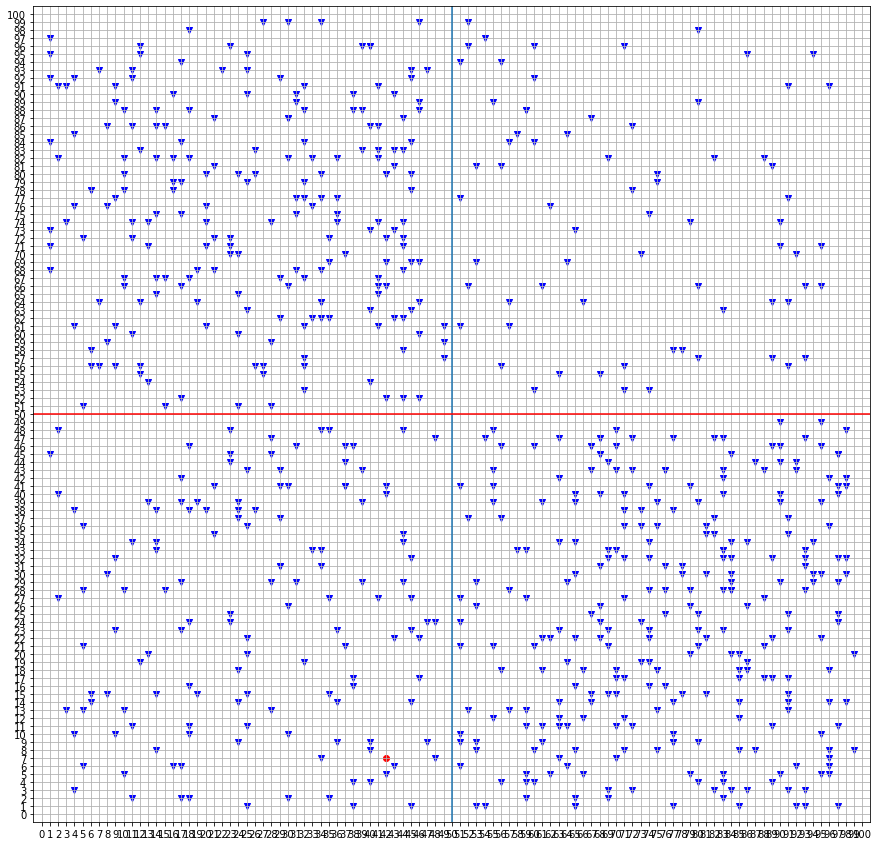

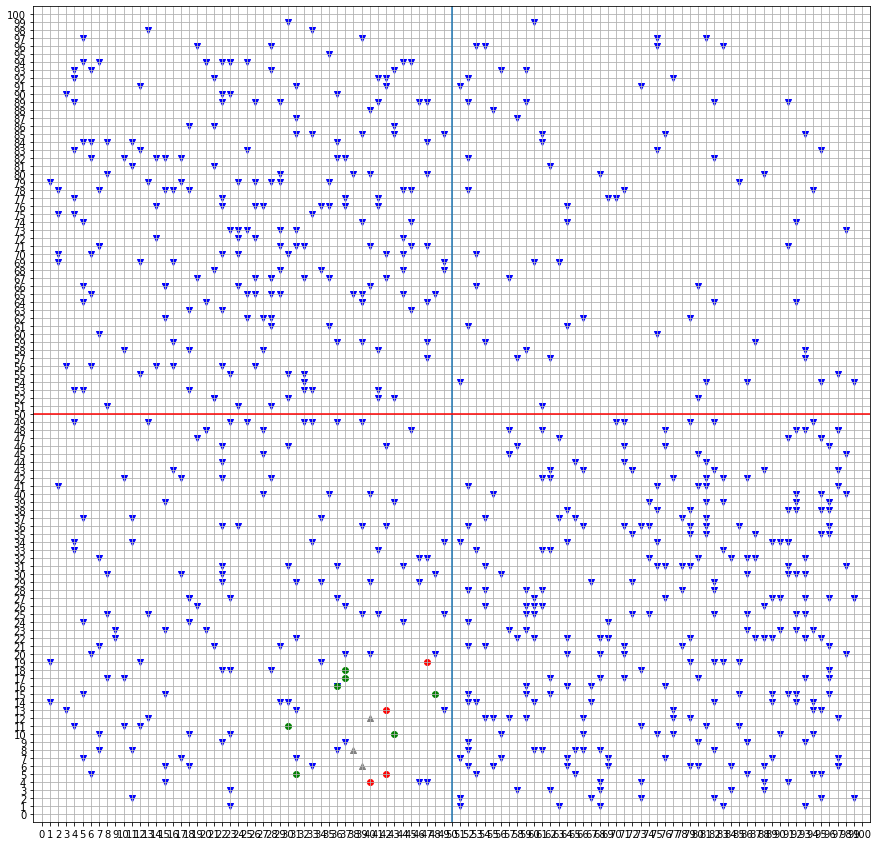

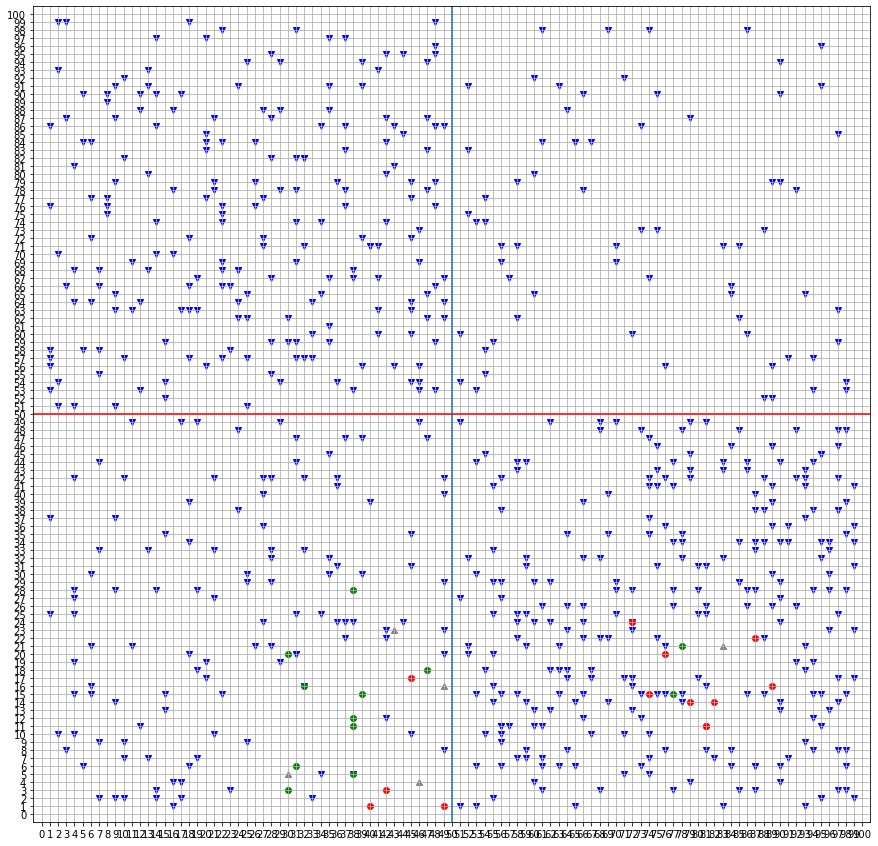

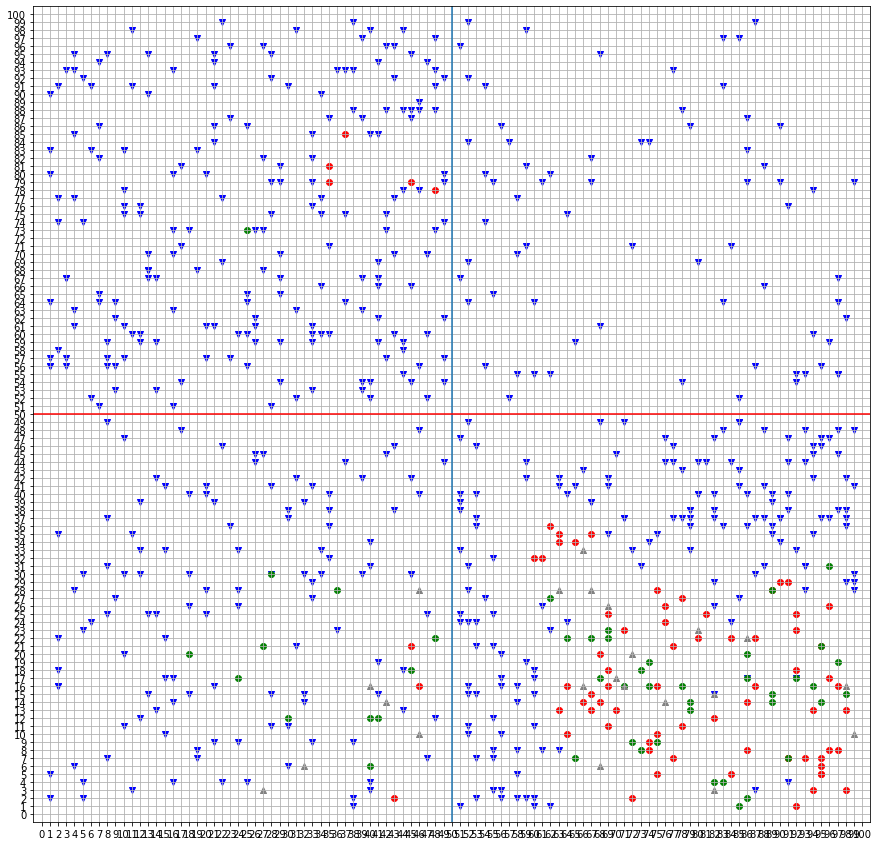

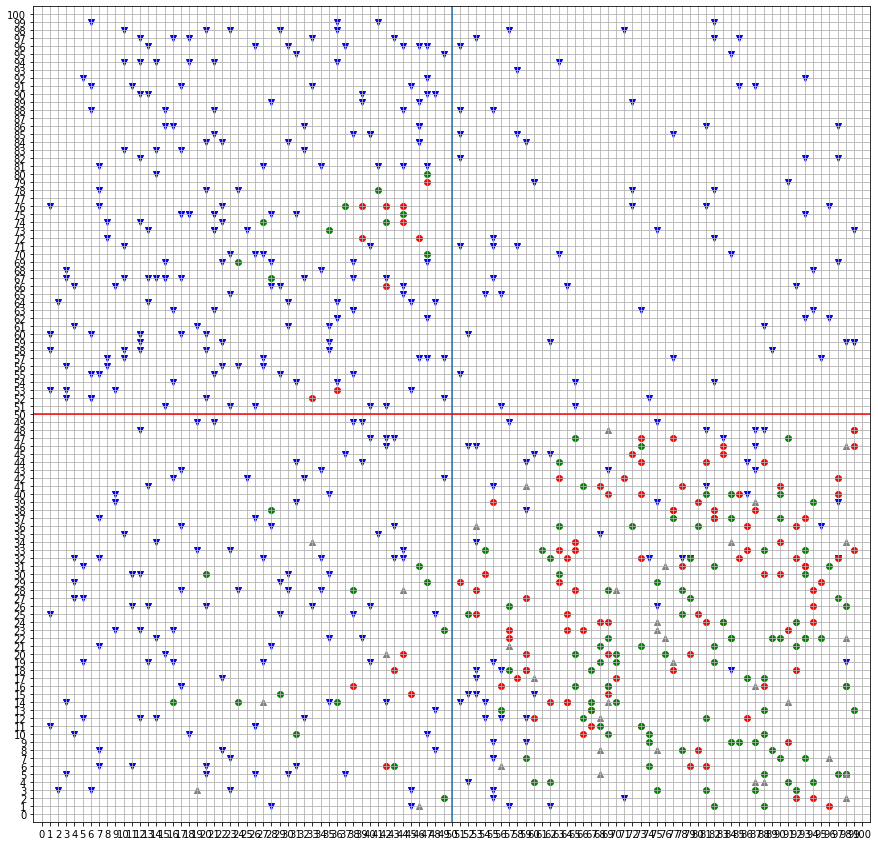

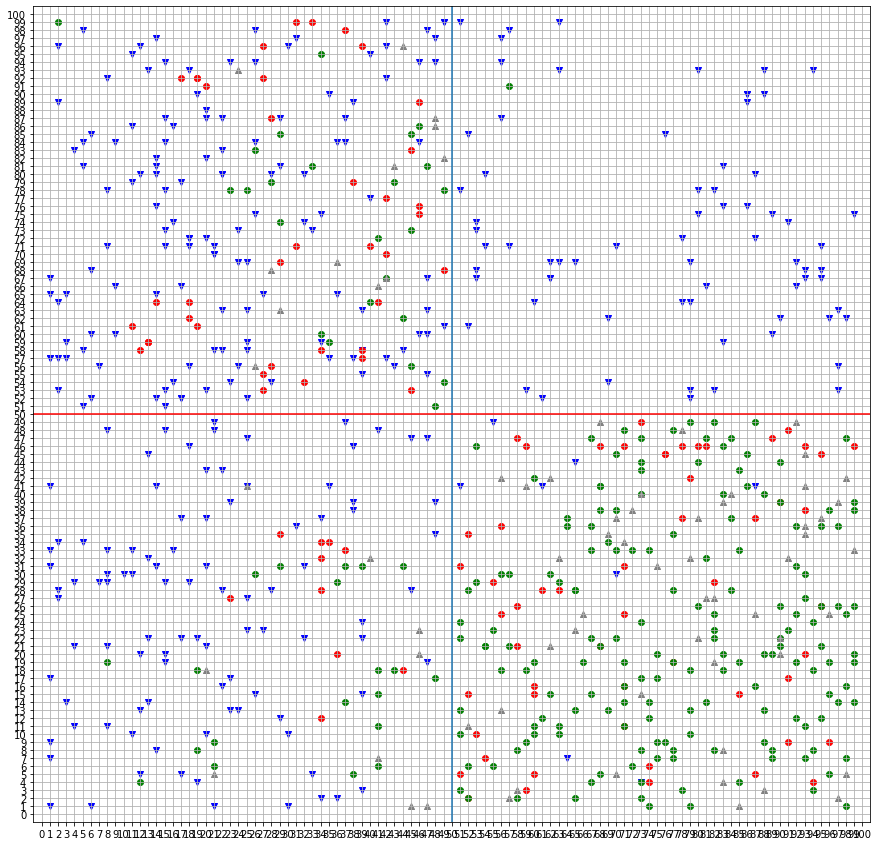

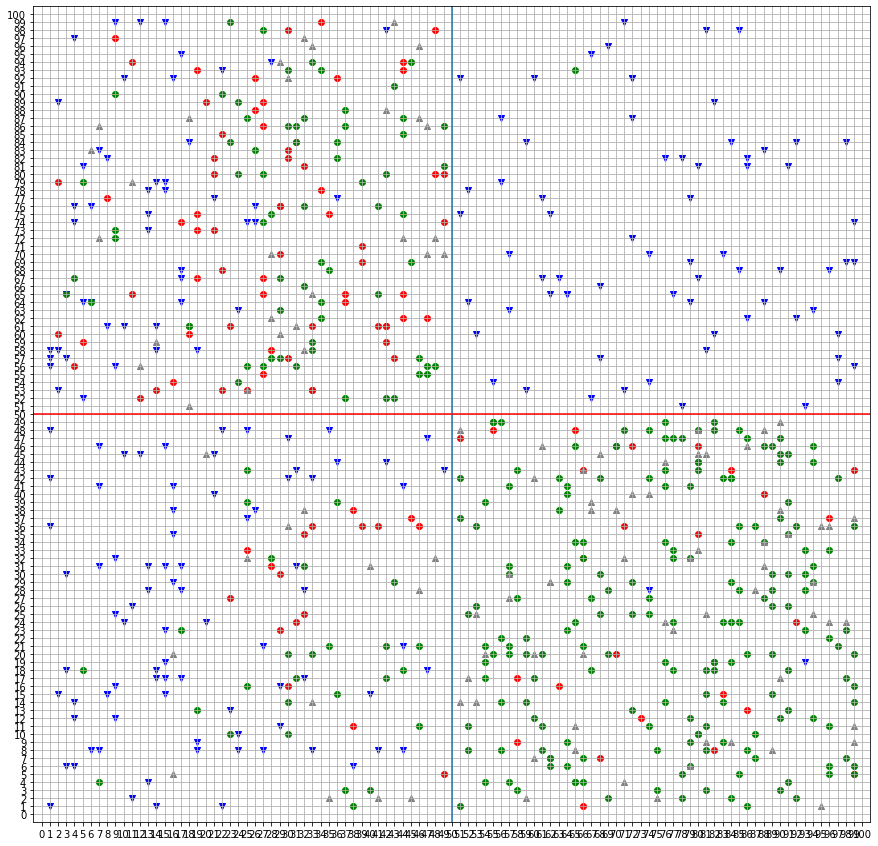

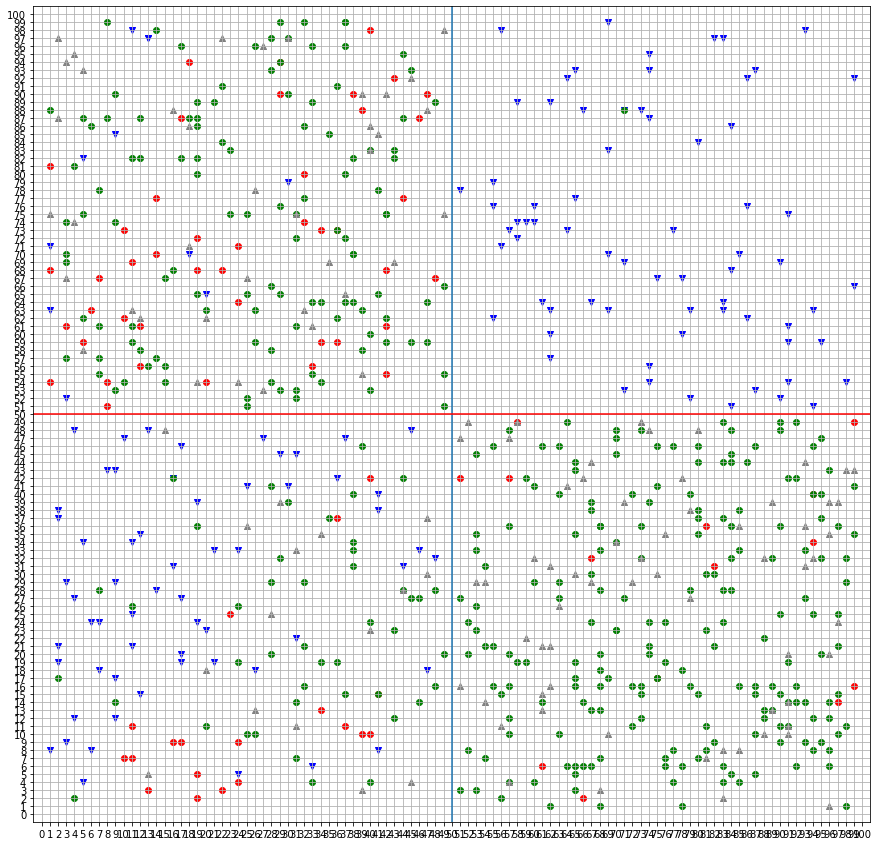

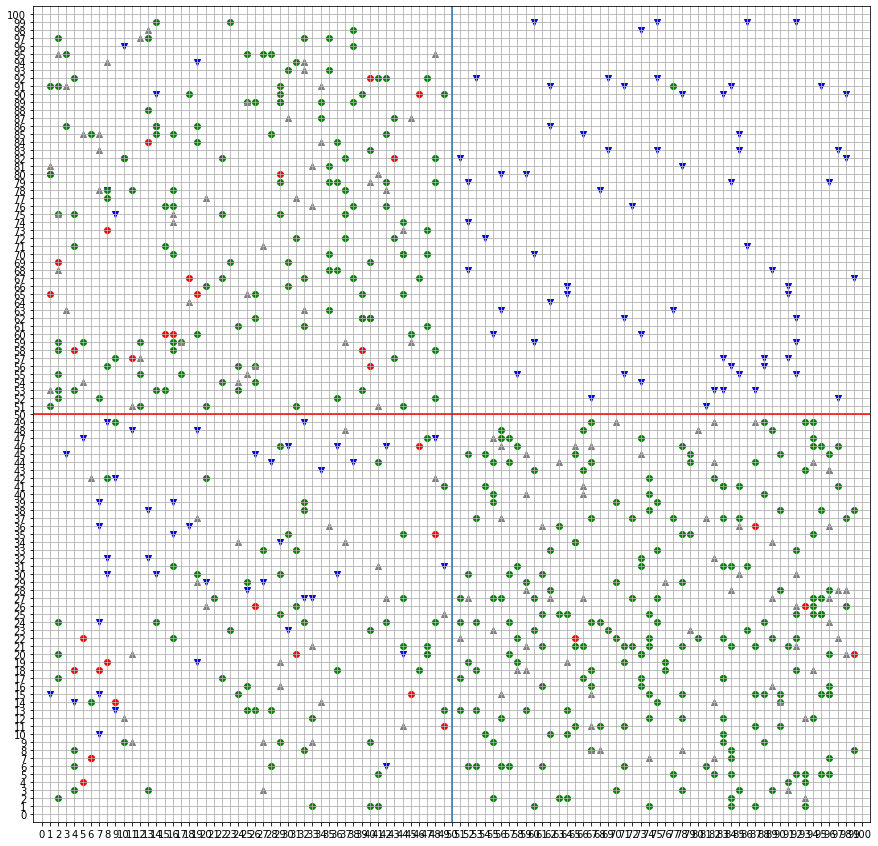

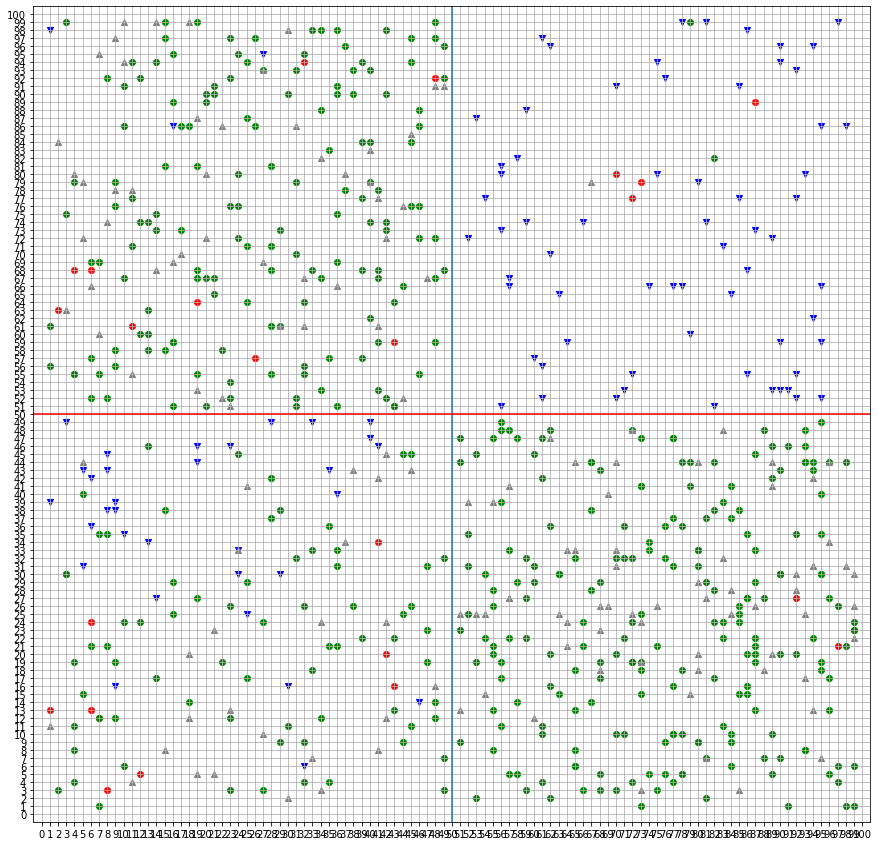

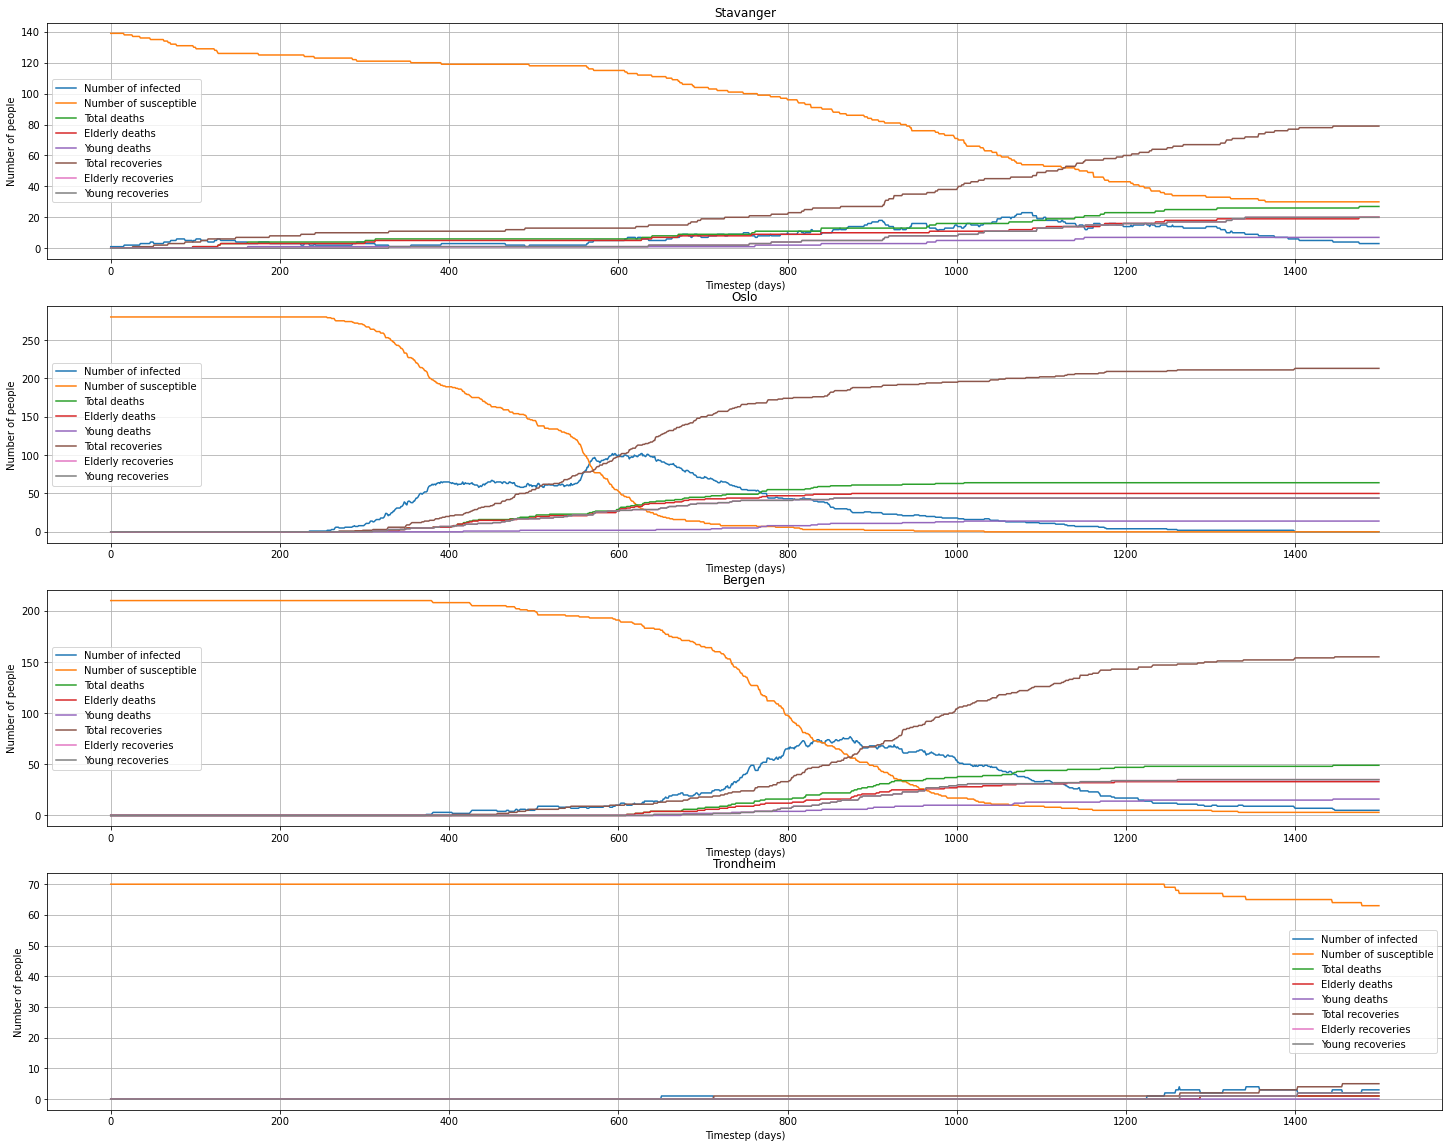

In [81]:
def one_simulation_runner(steps =1500, plot_state = False, population_size=700,no_init_infected=1,nx=100,ny=100, q=0.9, recovery_rate = 0.005, death_rate_old = 0.005 ,death_rate_young = 0.0005, 
    travel_rate_asymptomatics = 0.16,social_distancing_rate = 0.8, social_distancing_duration = 50, nth_elderly = 3):
    """ Function that runs one simulation and plots results
    """
    simulator_instance = RandomWalkEpidemicSimulator(population_size,no_init_infected,nx,ny,q, recovery_rate, death_rate_old, death_rate_young, 
    travel_rate_asymptomatics,social_distancing_rate, social_distancing_duration, nth_elderly)
    city_data_saver = [StateSaver() for i in Citizenship]
    
    simulator_instance.simulate(steps, city_data_saver, plot_state)

    t =np.arange(steps)

    fig, ax =plt.subplots(4, figsize = (25,20))
    city_name_list = ['Stavanger', 'Oslo', 'Bergen', 'Trondheim']
    for i in range(0,4):
        ax[i].plot(t,city_data_saver[i].infectious_cumulative, label ='Number of infected')
        ax[i].plot(t,city_data_saver[i].susceptible_cumulative, label = 'Number of susceptible')
        ax[i].plot(t,city_data_saver[i].dead_cumulative, label = 'Total deaths')
        ax[i].plot(t,city_data_saver[i].dead_elderly, label = 'Elderly deaths')
        ax[i].plot(t,city_data_saver[i].dead_young, label ='Young deaths')
        ax[i].plot(t,city_data_saver[i].recoveries_cumulative, label = 'Total recoveries')
        ax[i].plot(t,city_data_saver[i].recoveries_elderly, label = 'Elderly recoveries')
        ax[i].plot(t,city_data_saver[i].recoveries_young, label = 'Young recoveries')
        ax[i].grid()
        ax[i].set_ylabel('Number of people')
        ax[i].set_xlabel('Timestep (days)')
        ax[i].set_title(str(city_name_list[i]))
        ax[i].legend()
    
one_simulation_runner(plot_state=True)

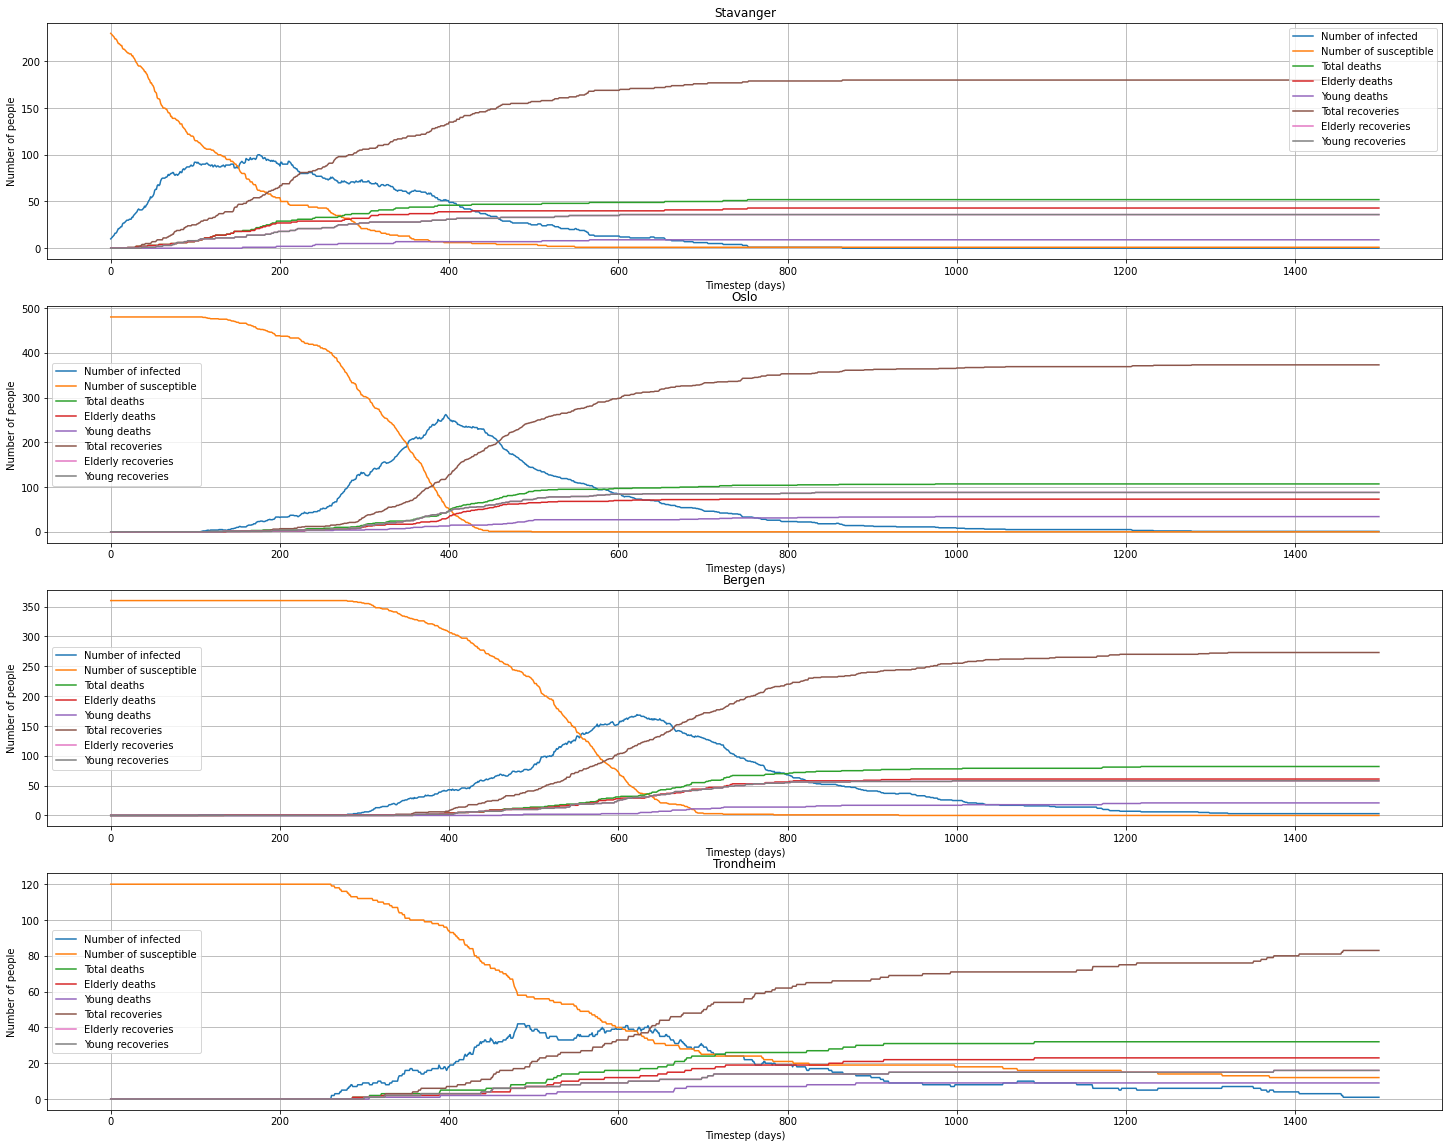

In [39]:
one_simulation_runner(population_size = 1200, no_init_infected = 10)

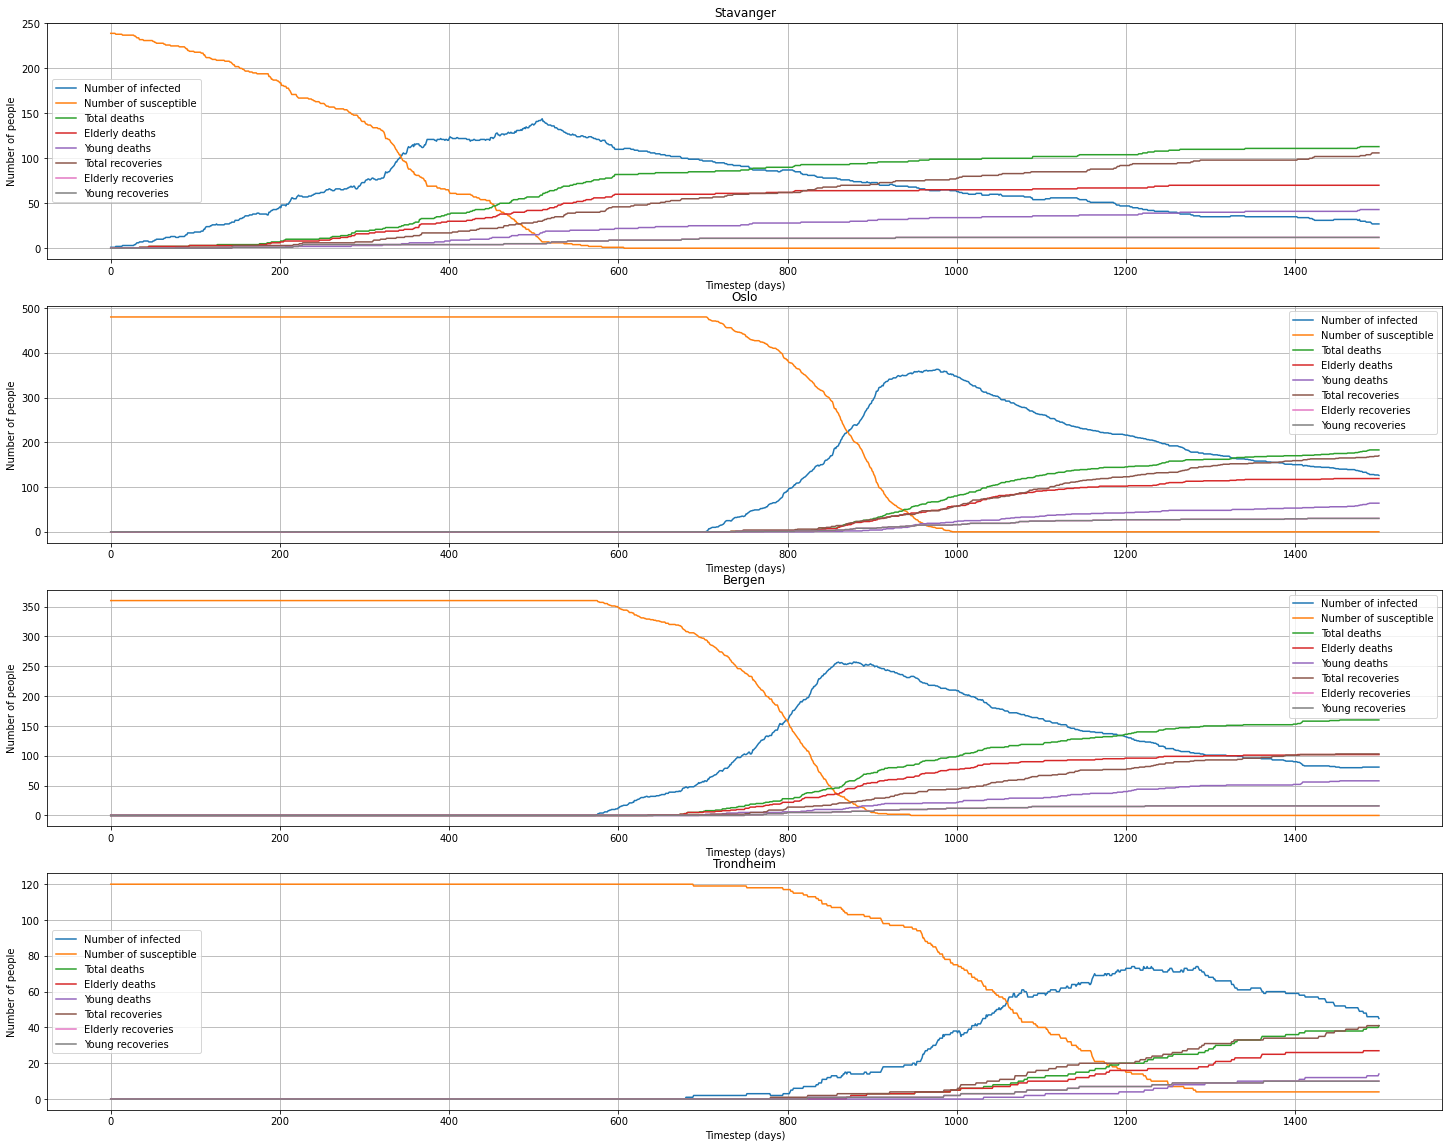

In [30]:
one_simulation_runner(steps = 1500, population_size =1200, q=0.5)

## Explanation of plots:

In the first instances we run the state plotter which illustrates how the walkers move, collide and infect. For the other plots, only the results are shown. 
Here we have run the simulation models with some varying degrees of parameters. The simulations are all set off with one initial infection in Stavanger, which spreads to the other cities as the timesteps progress. We may note that even without changing the parameters the resulting plots may vary greatly, where even in some instances the infection dies out immediately. Of course, this is a result of the stochastic nature of the simulation. Most often we see the initial spread start in Stavanger, which spreads to the other cities after some time has passed. An interesting aspect of this is then how the disease spread over differing population densities. Oslo, being the densest, often ends up having its whole population infected rater rapidly after the onset of the first infection within the city. Correspondingly Trondheim, with the sparsest density, tends to fair a little bit better. However, our simulation paints a somewhat bleak picture as in more often than not, the whole population ends up contracting the virus. This may in turn be caused by some of the limitations of the model, as we, for example, do not model quarantines or safe zones, which might have contributed to the results where the infection is stopped before the whole population is infected.    

## Running several simulations and comparing to actual data

Here we do as in the previous exercises and run 300 instances of the simulation, and compare the plots to actual covid data from norway.


In [63]:
steps = 1500
runs = 300



def simulation_runner(runs=runs, steps=steps, population_size=700, no_init_infected=1,nx=100,ny=100, q=0.9, recovery_rate = 0.005, death_rate_old = 0.005 ,death_rate_young = 0.0005, 
    travel_rate_asymptomatics = 0.16,social_distancing_rate = 0.8, social_distancing_duration = 50, nth_elderly = 3):
    """ Function that takes in siomulation parameters and runs "runs"(number of runs) simulations
    outputs runs by steps size np.arrays of healty and sick data.
    """
    simulation_instance = RandomWalkEpidemicSimulator(population_size,no_init_infected,nx,ny,q, recovery_rate, death_rate_old, death_rate_young, 
    travel_rate_asymptomatics,social_distancing_rate, social_distancing_duration, nth_elderly)
    city_data_saver = [StateSaver() for i in Citizenship]
    
    for i in range(runs):
        simulation_instance.simulate(steps, city_data_saver)
    
    infectious_data = [np.array(city_data_saver[i].infectious_cumulative).reshape(runs,steps) for i in range(4)]
    susceptible_data = [np.array(city_data_saver[i].susceptible_cumulative).reshape(runs,steps) for i in range(4)]
    dead_data = [np.array(city_data_saver[i].dead_cumulative).reshape(runs,steps)for i in range(4)]
    
    return infectious_data, susceptible_data, dead_data 

#infectious_data, susceptible_data, death_data = simulation_runner()

# for i in range(4):
#     np.savetxt('simulation_data/Exercise4/Infectious_data_'+str(Citizenship(i).name),infectious_data[i])
#     np.savetxt('simulation_data/Exercise4/Susceptible_data_'+str(Citizenship(i).name),susceptible_data[i])
#     np.savetxt('simulation_data/Exercise4/Death_data_'+str(Citizenship(i).name),death_data[i])



In [123]:
infectious_data =[]
susceptible_data =[]
death_data =[]
for i in range(4):
    infectious_data.append(np.loadtxt('simulation_data/Exercise4/Infectious_data_'+str(Citizenship(i).name)))
    susceptible_data.append(np.loadtxt('simulation_data/Exercise4/Susceptible_data_'+str(Citizenship(i).name)))
    death_data.append(np.loadtxt('simulation_data/Exercise4/Death_data_'+str(Citizenship(i).name)))


datalist = [infectious_data,death_data]

In [128]:
def simulation_plot_setup(data,data_index,city_index, t): 
    simfig, ax = plt.subplots(figsize = (10,5))

    data_lower = data.mean(axis= 0) - 0.5*data.std(axis =0)
    data_upper = data.mean(axis= 0) + 0.5*data.std(axis =0) 

    names_list = ['Infected','Deaths']
    main_color_list = ['Blue', 'Red', 'Green', 'Orange']
    fill_color_list =['lightblue', 'pink', 'lightgreen', 'lightsalmon']
    
    ax.plot(t,data.mean(axis=0), color =main_color_list[data_index], label = names_list[data_index] + str(Citizenship(city_index).name))
    ax.fill_between(t,data_lower,data_upper,color=fill_color_list[data_index] ,label ='Simulation sample-std spread')
    ax.set_title(str(Citizenship(city_index).name)+ ' Data from simulation')
    ax.set_xlabel('Timestep (days)')
    ax.set_ylabel('Population count')
    ax.legend()
    ax.grid()
    return ax


In [142]:
covidfile = pd.read_csv('Covid_data\corona_data.dat', sep ='\t')

norway_data = covidfile.loc[covidfile['LOCATION'] == 'Norway']
norway_confirmed = norway_data['CONFIRMED'] -norway_data['DEATHS']-norway_data['RECOVERED']
norway_deaths =norway_data['DEATHS']


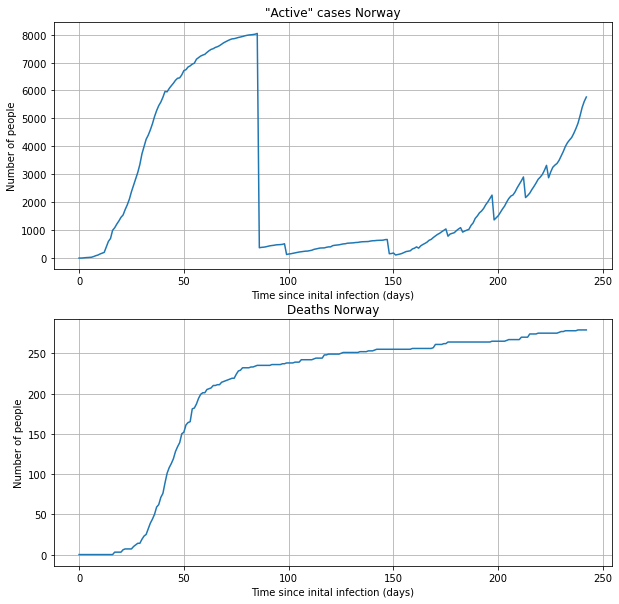

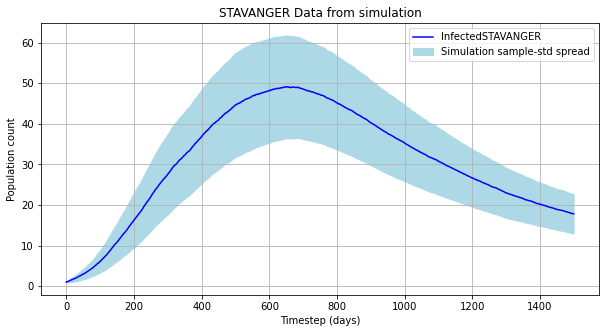

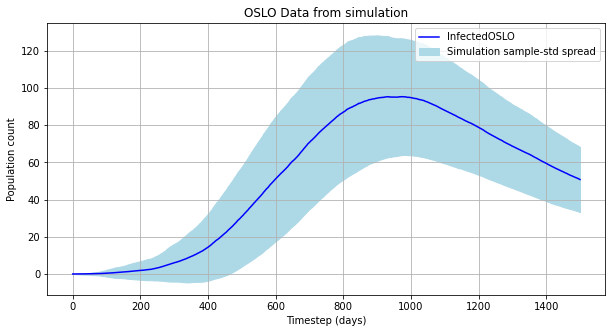

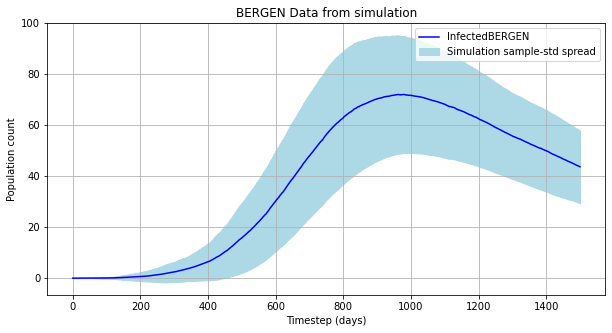

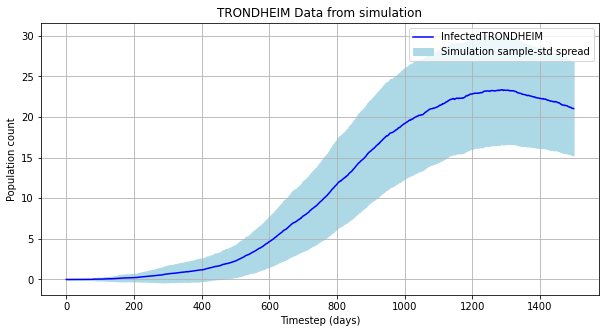

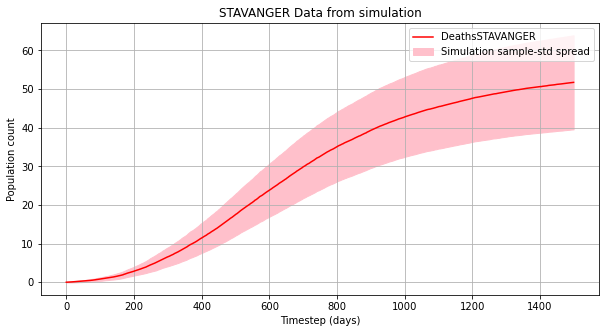

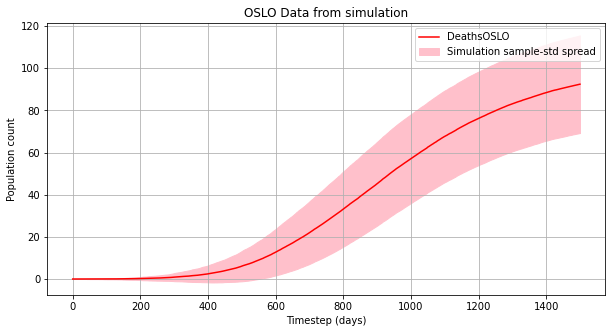

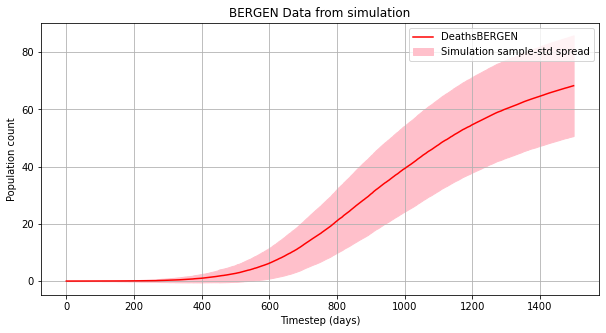

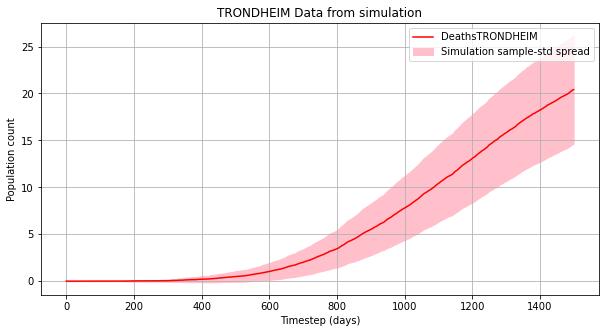

In [143]:
maybelastfig, axes = plt.subplots(2, figsize=(10,10))
axes[0].plot(np.arange(len(norway_confirmed)), norway_confirmed)
axes[1].plot(np.arange(len(norway_confirmed)), norway_deaths)
axes[0].set_title('"Active" cases Norway')
axes[1].set_title('Deaths Norway')

for i in range(2): 
    axes[i].set_xlabel('Time since inital infection (days)')
    axes[i].set_ylabel('Number of people')
    axes[i].grid()
    

for i in range(2):
    for j in range(4):
        simulation_plot_setup(datalist[i][j], i, j, t =np.arange(steps))
     


We see some vague similarities between the recorded data and the simulation plots. Especially the dip in number of active cases seems to be because of a sudden recording of recoveries rather than a gradual downward shift after a peak period as the simulation predicts. We see some vague similarities between the recorded data and the simulation plots. Especially the dip in number of active cases seems to be because of a sudden recording of recoveries rather than a gradual downward shift after a peak period as the simulation predicts. But still, even with the sudden dip in actual data one can argue the two plots have an overall similar shape: Initial rapid increase followed by some decreasing (social-distancing, governmental policies), and (not as apparent in the simulation data as we had hoped) a resurgence, likely caused by alleviation of these policies. Also, notably, the death rate seems steeper for real life data which might indicate that we were to optimistic when setting the death rate for the simulation.